# Imports & Other Setup

In [1]:
# !conda activate n2v
%load_ext autoreload

import numpy as np
from matplotlib import pyplot as plt
import torch
import zarr
import os
import daisy

from funlib.learn.torch.models import UNet, ConvPass
import gunpowder as gp
import logging
logging.basicConfig(level=logging.INFO)

# from this repo
import loser
from boilerPlate import BoilerPlate
from noise2gun import *
from ng_view_zarr import ng_view_zarr
# from segway.tasks.make_zarr_from_tiff import task_make_zarr_from_tiff_volume as tif2zarr

2021-09-01 21:11:38.233371: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
#Pick a GPU or 2
torch.cuda.set_device(3)

# Set Parameters (including data source, training variables, destination, etc.)

In [5]:
train_source = '/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/CARE/mCTX/450p_stacks/mCTX_17keV_30nm_512c_first256.zarr' #EXPECTS ZARR VOLUME

tensorboard_path = '/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/raygun/n2g/tensorboard/'
model_name = 'noise2gun_mCTX30nm_450p'
model_path = '/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/raygun/n2g/models/'
voxel_size=gp.Coordinate((30, 30, 30)) # set for each dataset (may be able to get from zarr)

side_length = 64#12 # in voxels for prediction (i.e. network output) - actual used ROI for network input will be bigger for valid padding
unet_depth = 4 # number of layers in unet
downsample_factor = 2
conv_padding = 'valid'
num_fmaps = 12
fmap_inc_factor=5
perc_hotPixels = 0.198
constant_upsample=True

num_epochs = 10000
batch_size = 1
init_learning_rate = 1e-5#0.0004#1e-6 # init_learn_rate = 0.0004
log_every=100

### Make sure data source is a **zarr** 

## Using Noise2Gun class from noise2gun.py

In [17]:
%autoreload
from noise2gun import *

In [2]:
data_path = '/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/CARE/mCTX/450p_stacks/mCTX_17keV_30nm_512c_first256.zarr/volumes'

model_name = 'noise2gun_mCTX30nm_450p_20210824'

n2g = Noise2Gun(train_source=data_path,
                voxel_size=gp.Coordinate((30, 30, 30)),
                out_path=data_path,
                model_name = model_name,
                model_path = '/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/raygun/n2g/models/',
                tensorboard_path = '/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/raygun/n2g/tensorboard/'+model_name,
                num_epochs = 30000,
                init_learning_rate=0.0004)


# Build Gunpowder Pipeline for Training

In [3]:
n2g.build_training_pipeline()

# Train

### Test snapshot first:

INFO:gunpowder.torch.nodes.train:Resuming training from iteration 30000
INFO:gunpowder.torch.nodes.train:Loading /n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/raygun/n2g/models/noise2gun_mCTX30nm_450p_20210824_checkpoint_30000
INFO:gunpowder.torch.nodes.train:Using device cuda
INFO:gunpowder.nodes.precache:starting new set of workers (48, cache size 50)...
INFO:gunpowder.nodes.generic_train:Train process: iteration=30001 loss=0.000000 time=12.274493
INFO:gunpowder.producer_pool:terminating workers...
INFO:gunpowder.producer_pool:joining workers...
INFO:gunpowder.producer_pool:done


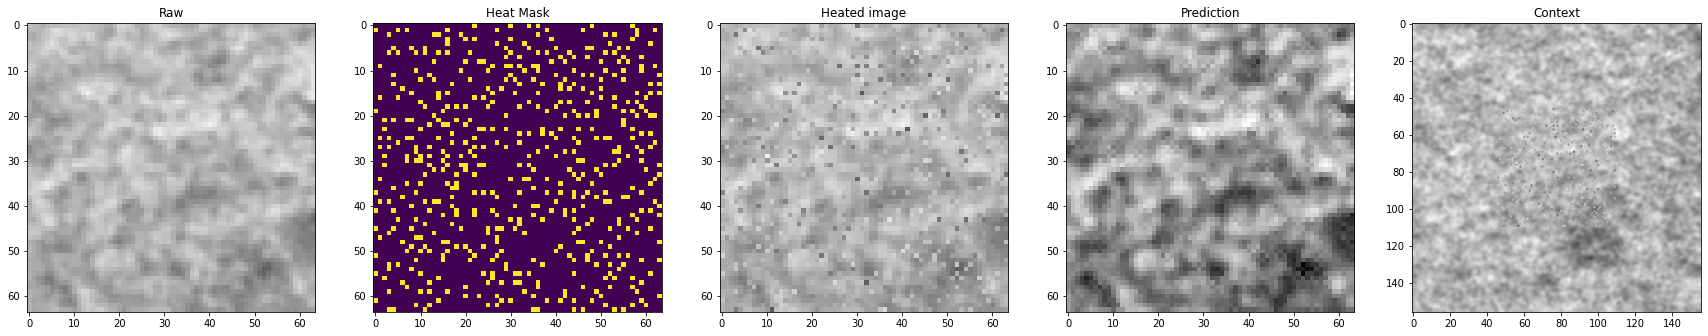

In [4]:
batch = n2g.test_train()

# Full training is best to run from the command prompt in a background process:
Write a script similar to *example_training_script.py*, then run with the following command:
```bash
$ nohup python example_training_script.py &
```

# Predict

### Take a snapshot first to examine:

INFO:gunpowder.torch.nodes.predict:Predicting on gpu


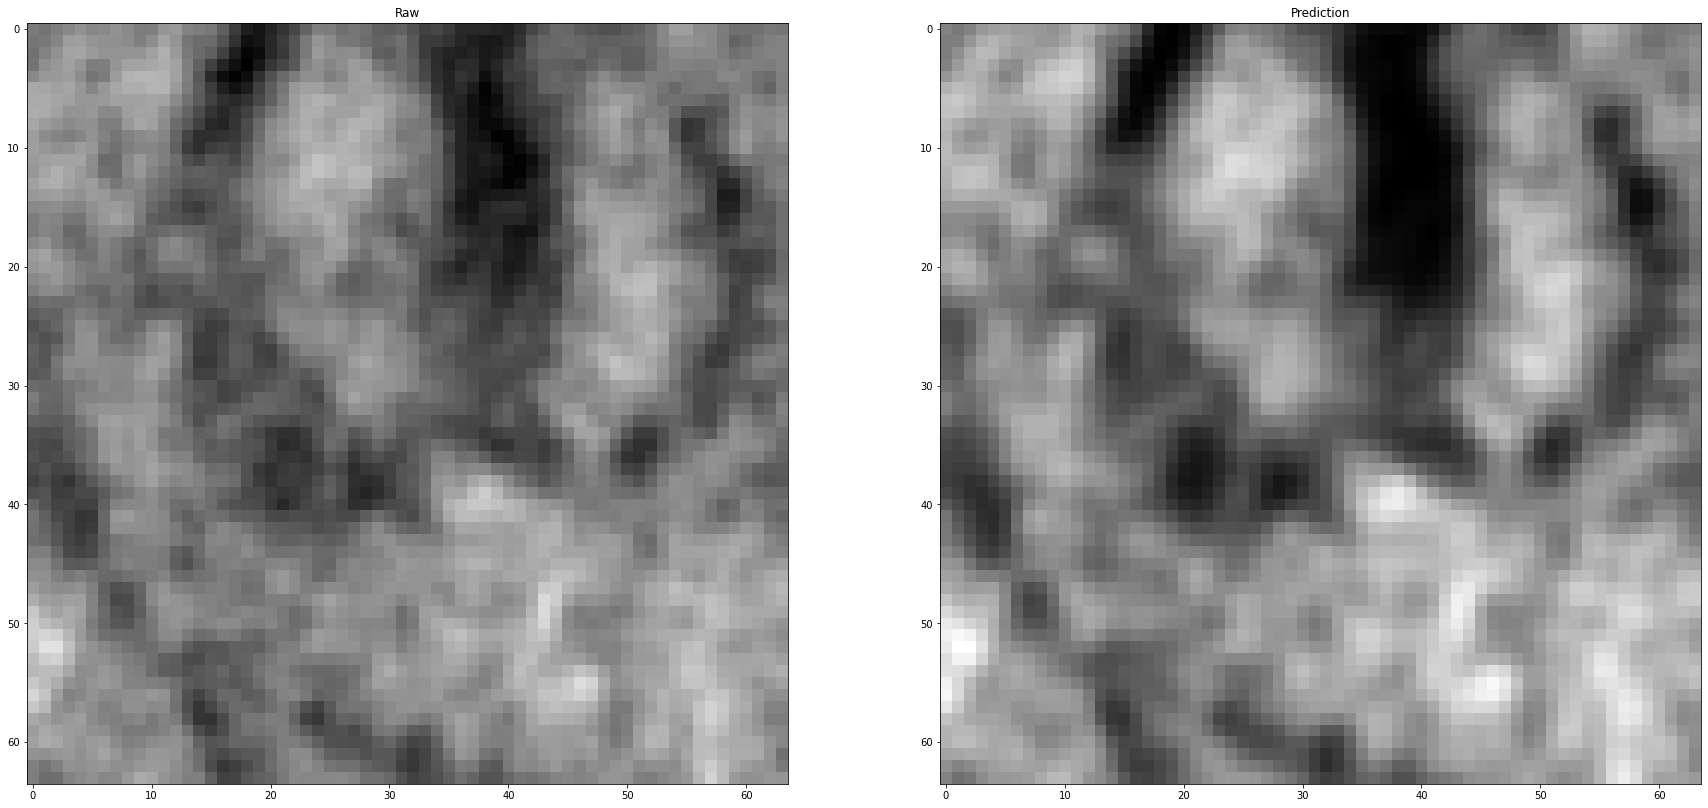

In [5]:
batch = n2g.test_prediction()

## Render full
This may run fast enough to call from a notebook like this, otherwise it can be run similar to the training above with a script such as that in *example_rending_script.py*:
```bash
$ nohup python example_rendering_script.py
```

In [3]:
n2g.render_full()

INFO:gunpowder.nodes.scan:scanning over 147 chunks


Full rendering pipeline declared. Building...
Starting full volume render...


0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
147it [01:49,  1.35it/s]

Finished.


## Check output:

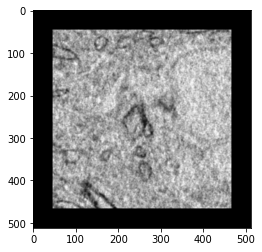

In [4]:
dataset = daisy.open_ds(data_path[:-7], 'volumes/noise2gun_mCTX30nm_450p_20210824')
mid = dataset.shape[0] // 2
plt.imshow(dataset.data[mid,], cmap='gray')#, vmin=0., vmax=.5)

# Visualize with Neuroglancer:

In [22]:
viewer = ng_view_zarr('/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/CARE/mCTX/450p_stacks/mCTX_17keV_30nm_512c_first256.zarr')

[ManagedLayer("noise2gun_mCTX30nm_450p_20210824",{"type": "image", "source": "<LocalVolume>", "name": "noise2gun_mCTX30nm_450p_20210824"})]
[ManagedLayer("noise2gun_mCTX30nm_450p_20210824",{"type": "image", "source": "<LocalVolume>", "name": "noise2gun_mCTX30nm_450p_20210824"}), ManagedLayer("train",{"type": "image", "source": "<LocalVolume>", "name": "train"})]
http://lee-htem-gpu0:43163/v/a0f8f6e39eebb874dc6f7dedd9533a3761b2e338/
http://10.117.28.249:43163/v/a0f8f6e39eebb874dc6f7dedd9533a3761b2e338/


# Scratch work and trouble shooting

In [46]:
src = '/n/groups/htem/ESRF_id16a/tomo_ML/ReducedAnglesXray/CARE/mCTX/450p_stacks/mCTX_17keV_30nm_512c_first256.zarr/volumes'
data_file = zarr.open(src)
dataset = daisy.open_ds(src[:-7], 'volumes/noise2gun_mCTX30nm_450p_20210824')
layers = [array for array in data_file.array_keys()]
layer = layers[0]

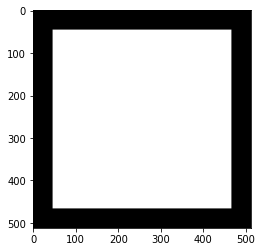

In [47]:
plt.imshow(dataset.data[128,], cmap='gray')#, vmin=0., vmax=.5)

In [48]:
dataset.data[:].max()
# dimensions = dataset.voxel_size * dataset.shape


0.4351688

In [39]:
data_file['noise2gun_mCTX30nm_450p_20210824']

<zarr.core.Array '/noise2gun_mCTX30nm_450p_20210824' (256, 512, 512) float32>